In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path

from post.files import parse_metrics_log, parse_job_log
from post.plots import get_figa, plot_metrics, plot_metric, make_axis_great_again, plot_epochs
from post.utils import parse_epochs

In [3]:
tesi_folder = Path('~/Scuola/now/thesis').expanduser()
milestones = tesi_folder / 'milestones'
current_milestone = milestones / '06.05_12.05_solving_the_MLP_problem'

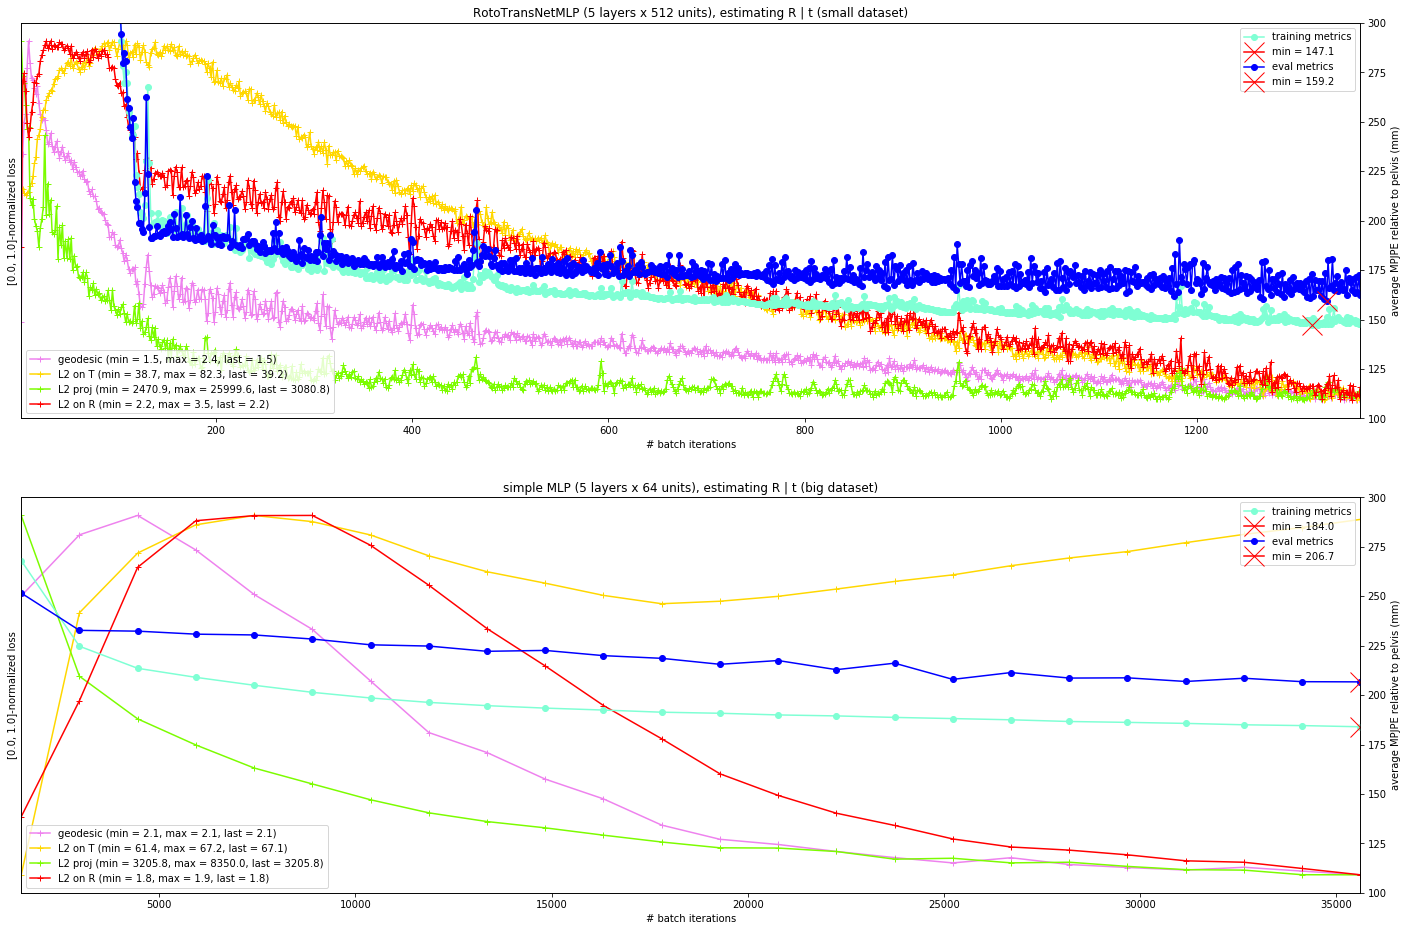

In [123]:
fig, axis = get_figa(2, 1, heigth=8, width=24)

training_batch_size = 8

job_id = '15611582'
exp_name, train_data_amount, _, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
batch_amount_per_epoch = train_data_amount / training_batch_size
xrange = np.arange(1, len(epochs) + 1) * batch_amount_per_epoch
metrics_ylim = [1e2, 3e2]

ax = axis.ravel()[0]
plot_epochs(
    ax, epochs, xrange,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    normalize_loss=(0, 1),
    title='RotoTransNetMLP (5 layers x 512 units), estimating R | t (small dataset)',
    metric_ylabel='average MPJPE relative to pelvis (mm)',
    xlabel='# batch iterations'
)
make_axis_great_again(ax, xlim=xrange, ylim=None, hide_y=True)

job_id = '15500638'
exp_name, train_data_amount, _, epochs = parse_job_log(current_milestone / '{}.out'.format(job_id))
batch_amount_per_epoch = train_data_amount / training_batch_size
xrange = np.arange(1, len(epochs) + 1) * batch_amount_per_epoch
metrics_ylim = [1e2, 3e2]

ax = axis.ravel()[1]
plot_epochs(
    ax, epochs, xrange,
    train_metric_ylim=metrics_ylim,
    eval_metric_ylim=metrics_ylim,
    normalize_loss=(0, 1),
    title='simple MLP (5 layers x 64 units), estimating R | t (big dataset)',
    metric_ylabel='average MPJPE relative to pelvis (mm)',
    xlabel='# batch iterations'
)
make_axis_great_again(ax, xlim=xrange, ylim=None, hide_y=True)

# MLP_long_VS_short.png